<a href="https://colab.research.google.com/github/lloyd31/CNNDetection/blob/master/CNNBasedDetector_Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Clone the CNN repo
!git clone https://github.com/lloyd31/CNNDetection.git

Cloning into 'CNNDetection'...
remote: Enumerating objects: 691, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 691 (delta 32), reused 56 (delta 28), pack-reused 626
Receiving objects: 100% (691/691), 6.51 MiB | 23.73 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [2]:
%cd /content/CNNDetection
%pip install -r requirements.txt
!bash weights/download_weights.sh
%cd /content

/content/CNNDetection
--2022-03-20 23:16:36--  https://www.dropbox.com/s/2g2jagq2jn1fd0i/blur_jpg_prob0.5.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2g2jagq2jn1fd0i/blur_jpg_prob0.5.pth [following]
--2022-03-20 23:16:36--  https://www.dropbox.com/s/raw/2g2jagq2jn1fd0i/blur_jpg_prob0.5.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb73a52df38dbff975d2cac2cc2.dl.dropboxusercontent.com/cd/0/inline/Bh288I9K1zEpQ11ZCduY-y_tXhCNUV0Gxme-1bQd7EyqfCOwzRsIeZPQxMcfc0qklcObtYSaIFiJCCjbA0Q8c7mNPdZYf9SZKuFIcMqFkA37gVNEvxEULV-liZPcu9TecKNzA4hr2-vriwQL1gr8KrY5JnigORUuImYEiPkVDO2z1w/file# [following]
--2022-03-20 23:16:36--  https://ucb73a52df38dbff975d2cac2cc2.dl.dropboxusercontent.com/cd/0/inline/Bh288I9K1zEpQ1

In [3]:
!git clone https://github.com/lloyd31/gan-analysis-db.git

Cloning into 'gan-analysis-db'...
remote: Enumerating objects: 8205, done.
remote: Counting objects: 100% (948/948), done.
remote: Compressing objects: 100% (947/947), done.
remote: Total 8205 (delta 1), reused 946 (delta 0), pack-reused 7257
Receiving objects: 100% (8205/8205), 528.06 MiB | 26.36 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (8200/8200), done.


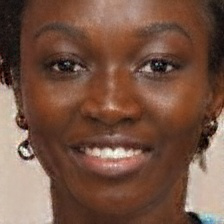

In [37]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image

trans = transforms.Compose([ transforms.Resize((224,224))])
img = trans(Image.open('/content/gan-analysis-db/ifakePath/iFakeFaceDB/100F/010013.jpg').convert('RGB'))
img

In [4]:
!ls -l

total 12
drwxr-xr-x 9 root root 4096 Mar 20 23:16 CNNDetection
drwxr-xr-x 9 root root 4096 Mar 20 23:17 gan-analysis-db
drwxr-xr-x 1 root root 4096 Mar  9 14:48 sample_data


**Phase I: Overall real + Fake set up**

In [5]:
import os
import shutil

In [6]:
## Default sustem configuration needed to run the application

mysys = {
    'testDir':'',
    'realPathSuffix':'',
    'fakePathSuffix':'',
    
    'cnnPeopleRealPath':'/content/gan-analysis-db/cnnTest/person/0_real/',
    'cnnPeopleFakePath':'/content/gan-analysis-db/cnnTest/person/1_fake/',

    'cnnCarRealPath':'/content/gan-analysis-db/cnnTest/car/0_real/',
    'cnnCarFakePath':'/content/gan-analysis-db/cnnTest/car/1_fake/',

    'cnnDogRealPath':'/content/gan-analysis-db/cnnTest/dog/0_real/',
    'cnnDogFakePath':'/content/gan-analysis-db/cnnTest/dog/1_fake/',

    'ganPath_100F_fake':'/content/gan-analysis-db/ifakePath/iFakeFaceDB/100F/',
    'ganPath_TPDNE_fake':'/content/gan-analysis-db/ifakePath/iFakeFaceDB/TPDNE/',

    'ganPath_100F_real':'',

    'pgGANPath_fake':'/content/gan-analysis-db/pggan_v2/test/',
    'styleGANPath_fake':'/content/gan-analysis-db/stylegan_celeba/test/',
    'starGANPath_fake':'/content/gan-analysis-db/stargan/validation/',

    'ffhqPath_real':'/content/gan-analysis-db/ffhqTest/ffhq/test/'
}

In [7]:
## Responsible to set up the test folder
def makeTestFolder():
  os.makedirs(os.path.join(mysys['testDir'], mysys['realPathSuffix']))
  print('REAL PATH: +1')
  os.makedirs(os.path.join(mysys['testDir'],mysys['fakePathSuffix']))
  print('FAKE PATH: +1')


In [8]:
## Responsible to clean up the copied destination
def cleanUpTestFolder():
  if os.path.isdir(mysys['testDir']):
    shutil.rmtree(mysys['testDir'])
    print('CLEANUP OF:'+mysys['testDir']+': +1')

In [9]:
## Responsible to set up the CNN model(Wang et. al).
### This needs the repository to be cloned
def setUpCNNApp():
  mysys['testDir'] = '/content/CNNDetection/testDir'
  mysys['realPathSuffix'] = '0_real'
  mysys['fakePathSuffix'] = '1_fake'
  makeTestFolder()

In [10]:
# The method is responsible to copy the data from a given folder (sub folders are not parsed here)

## Source Folder defines the path from where the data needs to be copied from.

## destination folder: Defines the location where the files need to be copied to. if not present, it
   ###is created and and the files are stored there. sub folder paths are also created if the they are missing

## limit: defines the number of files to be copied from the source folder. Default value is -1. At -1, all the images are copied from the given folder

## pfx: This param is used to control the existence of duplicate names. 
def copyTree(srcFolder, destFolder,limit=-1,pfx=''):
  if(os.path.exists(destFolder) == False):
    os.makedirs(destFolder)
  cnt =0
  
  for file in os.listdir(srcFolder):
    dfile=file

    if(os.path.exists(os.path.join(destFolder,file))):
      dfile=pfx+file

    shutil.copy2(os.path.join(srcFolder,file), os.path.join(destFolder,dfile))
    cnt+=1;
    if limit != -1 and limit < cnt:
      break

  print('files copied: ',srcFolder,' --> ',destFolder,': ',cnt)

##Phase I aims at including all the images available in the dataset and running a test against them
### Maintaining a real to fake ratio of  0.24 in all the models as described in Dang et. al

In [11]:

def setUpPhase_1():
  if os.path.isdir(mysys['testDir']):
    cleanUpTestFolder()
  setUpCNNApp()

  #copy real to testDir/real
  copyTree(srcFolder= mysys['cnnCarRealPath'], destFolder=os.path.join(mysys['testDir'],mysys['realPathSuffix']), pfx='d',limit=200)
  copyTree(srcFolder= mysys['cnnDogRealPath'], destFolder=os.path.join(mysys['testDir'],mysys['realPathSuffix']), pfx='d',limit=200)
  copyTree(srcFolder= mysys['cnnPeopleRealPath'], destFolder=os.path.join(mysys['testDir'],mysys['realPathSuffix']), pfx='p', limit=200)
  copyTree(srcFolder= mysys['ffhqPath_real'], destFolder=os.path.join(mysys['testDir'],mysys['realPathSuffix']))

  #copy fake to testDIR/fake
  copyTree(srcFolder= mysys['cnnCarFakePath'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']),pfx='c')
  copyTree(srcFolder= mysys['cnnDogFakePath'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']),pfx='d')
  copyTree(srcFolder= mysys['cnnPeopleFakePath'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']),pfx='p')

  copyTree(srcFolder= mysys['ganPath_100F_fake'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']))
  copyTree(srcFolder= mysys['ganPath_TPDNE_fake'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']))
  
  copyTree(srcFolder= mysys['pgGANPath_fake'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']))
  copyTree(srcFolder= mysys['styleGANPath_fake'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']))
  copyTree(srcFolder= mysys['starGANPath_fake'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']))

  fakeCount = len(os.listdir(os.path.join(mysys['testDir'],mysys['fakePathSuffix'])))
  realCount = len(os.listdir(os.path.join(mysys['testDir'],mysys['realPathSuffix'])))
  print('Fakes count: ',fakeCount)
  print('Real count: ',realCount)
  print('Real to Fake Ratio: {:.3f}'.format(realCount/fakeCount))

In [12]:
%cd /content/CNNDetection

/content/CNNDetection


In [13]:
!git pull origin master

From https://github.com/lloyd31/CNNDetection
 * branch            master     -> FETCH_HEAD
Already up to date.


In [14]:
%cd ../

/content


In [15]:
setUpPhase_1()

REAL PATH: +1
FAKE PATH: +1
files copied:  /content/gan-analysis-db/cnnTest/car/0_real/  -->  /content/CNNDetection/testDir/0_real :  200
files copied:  /content/gan-analysis-db/cnnTest/dog/0_real/  -->  /content/CNNDetection/testDir/0_real :  200
files copied:  /content/gan-analysis-db/cnnTest/person/0_real/  -->  /content/CNNDetection/testDir/0_real :  200
files copied:  /content/gan-analysis-db/ffhqTest/ffhq/test/  -->  /content/CNNDetection/testDir/0_real :  1000
files copied:  /content/gan-analysis-db/cnnTest/car/1_fake/  -->  /content/CNNDetection/testDir/1_fake :  200
files copied:  /content/gan-analysis-db/cnnTest/dog/1_fake/  -->  /content/CNNDetection/testDir/1_fake :  200
files copied:  /content/gan-analysis-db/cnnTest/person/1_fake/  -->  /content/CNNDetection/testDir/1_fake :  200
files copied:  /content/gan-analysis-db/ifakePath/iFakeFaceDB/100F/  -->  /content/CNNDetection/testDir/1_fake :  2000
files copied:  /content/gan-analysis-db/ifakePath/iFakeFaceDB/TPDNE/  -->  /

/content/CNNDetection


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Not cropping
Loading [1] datasets


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]
No handles with labels found to put in legend.


Average sizes: [224.00+/-0.00] x [224.00+/-0.00] = [0.05+/-0.00 Mpix]
Num reals: 1600, Num fakes: 6596
AP: 94.41, Acc: 35.54, Acc (real): 99.56, Acc (fake): 20.01, AUC: 81.19
------CONFUSION MATRIX------
[[1593    7]
 [5276 1320]]
----------------------------


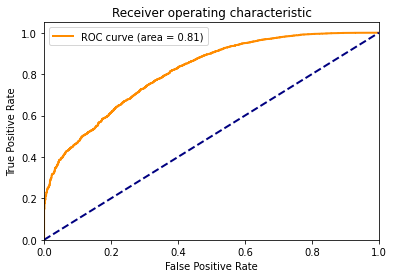

In [16]:
##Testing with cnn model-1  0.5% JPEG Compression, on PHASE I config :
%cd /content/CNNDetection/
%run demo_dir.py -d testDir -m weights/blur_jpg_prob0.5.pth

In [17]:
##Based on the Confusion Matrix Recall calculated is
print('Sensitivity',(1402/(5194+1402)))

##This is similar to the fake accuracy calculated by the model

Sensitivity 0.21255306246209824


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Not cropping
Loading [1] datasets


100%|██████████| 257/257 [01:05<00:00,  3.90it/s]
No handles with labels found to put in legend.


Average sizes: [224.00+/-0.00] x [224.00+/-0.00] = [0.05+/-0.00 Mpix]
Num reals: 1600, Num fakes: 6596
AP: 90.13, Acc: 41.62, Acc (real): 85.94, Acc (fake): 30.87, AUC: 71.06
------CONFUSION MATRIX------
[[1375  225]
 [4560 2036]]
----------------------------


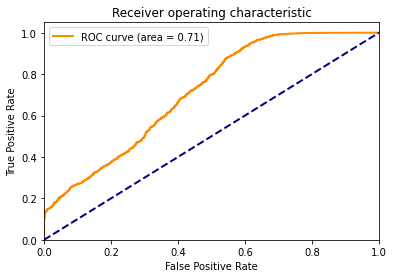

In [18]:
##Testing with model : 0.1% JPEG Compression, on PHASE I config
%run demo_dir.py -d testDir -m weights/blur_jpg_prob0.1.pth

In [ ]:
##Sensitivity##
print('Sensitivity: ', (1962/(1962+4634)))

Sensitivity:  0.2974530018192844


##Phase II aims at runnig tests over the images available in iFakeFaceDB dataset
###Real images are selected from ffhq dataset.

In [19]:

def setUpPhase_2():
  
  if os.path.isdir(mysys['testDir']):
    cleanUpTestFolder()
  setUpCNNApp()

  copyTree(srcFolder= mysys['ganPath_100F_fake'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']))
  copyTree(srcFolder= mysys['ganPath_TPDNE_fake'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']))

  copyTree(srcFolder= mysys['ffhqPath_real'], destFolder=os.path.join(mysys['testDir'],mysys['realPathSuffix']),limit=980)

  fakeCount = len(os.listdir(os.path.join(mysys['testDir'],mysys['fakePathSuffix'])))
  realCount = len(os.listdir(os.path.join(mysys['testDir'],mysys['realPathSuffix'])))
  print('Fakes count: ',fakeCount)
  print('Real count: ',realCount)
  print('Real to Fake Ratio: {:.3f}'.format(realCount/fakeCount))

In [20]:
setUpPhase_2()

CLEANUP OF:/content/CNNDetection/testDir: +1
REAL PATH: +1
FAKE PATH: +1
files copied:  /content/gan-analysis-db/ifakePath/iFakeFaceDB/100F/  -->  /content/CNNDetection/testDir/1_fake :  2000
files copied:  /content/gan-analysis-db/ifakePath/iFakeFaceDB/TPDNE/  -->  /content/CNNDetection/testDir/1_fake :  1999
files copied:  /content/gan-analysis-db/ffhqTest/ffhq/test/  -->  /content/CNNDetection/testDir/0_real :  981
Fakes count:  3999
Real count:  981
Real to Fake Ratio: 0.245


/content/CNNDetection


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Not cropping
Loading [1] datasets


100%|██████████| 156/156 [00:35<00:00,  4.39it/s]
No handles with labels found to put in legend.


Average sizes: [224.00+/-0.00] x [224.00+/-0.00] = [0.05+/-0.00 Mpix]
Num reals: 981, Num fakes: 3999
AP: 85.23, Acc: 20.40, Acc (real): 99.18, Acc (fake): 1.08, AUC: 62.11
------CONFUSION MATRIX------
[[ 973    8]
 [3956   43]]
----------------------------


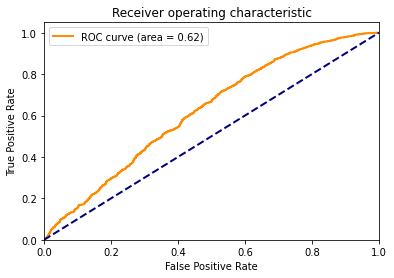

In [21]:
##Testing with model 1: 0.5% JPEG Compression
%cd /content/CNNDetection
%run demo_dir.py -d testDir -m weights/blur_jpg_prob0.5.pth

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Not cropping
Loading [1] datasets


100%|██████████| 156/156 [00:35<00:00,  4.37it/s]
No handles with labels found to put in legend.


Average sizes: [224.00+/-0.00] x [224.00+/-0.00] = [0.05+/-0.00 Mpix]
Num reals: 981, Num fakes: 3999
AP: 74.34, Acc: 24.54, Acc (real): 78.70, Acc (fake): 11.25, AUC: 41.29
------CONFUSION MATRIX------
[[ 772  209]
 [3549  450]]
----------------------------


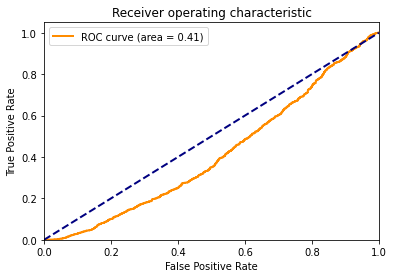

In [22]:
%run demo_dir.py -d testDir -m weights/blur_jpg_prob0.1.pth

## Phase 3: Running the build over the DFFD dataset

In [23]:
## Pahse 3 focuses on testing the model performance against the real and fakes provided in the DFFD dataset
def setUpPhase_3():
  if os.path.isdir(mysys['testDir']):
    cleanUpTestFolder()
  setUpCNNApp()

  #copy real to testDir/real
  
  copyTree(srcFolder= mysys['ffhqPath_real'], destFolder=os.path.join(mysys['testDir'],mysys['realPathSuffix']),limit=480)

  #copy fake to testDIR/fake
  copyTree(srcFolder= mysys['pgGANPath_fake'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']))
  copyTree(srcFolder= mysys['starGANPath_fake'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']))
  copyTree(srcFolder= mysys['styleGANPath_fake'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']))
  
  fakeCount = len(os.listdir(os.path.join(mysys['testDir'],mysys['fakePathSuffix'])))
  realCount = len(os.listdir(os.path.join(mysys['testDir'],mysys['realPathSuffix'])))
  print('Fakes count: ',fakeCount)
  print('Real count: ',realCount)
  print('Real to Fake Ratio: {:.3f}'.format(realCount/fakeCount))

In [24]:
setUpPhase_3()

CLEANUP OF:/content/CNNDetection/testDir: +1
REAL PATH: +1
FAKE PATH: +1
files copied:  /content/gan-analysis-db/ffhqTest/ffhq/test/  -->  /content/CNNDetection/testDir/0_real :  481
files copied:  /content/gan-analysis-db/pggan_v2/test/  -->  /content/CNNDetection/testDir/1_fake :  499
files copied:  /content/gan-analysis-db/stargan/validation/  -->  /content/CNNDetection/testDir/1_fake :  999
files copied:  /content/gan-analysis-db/stylegan_celeba/test/  -->  /content/CNNDetection/testDir/1_fake :  499
Fakes count:  1997
Real count:  481
Real to Fake Ratio: 0.241


/content/CNNDetection


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Not cropping
Loading [1] datasets


100%|██████████| 78/78 [00:24<00:00,  3.20it/s]
No handles with labels found to put in legend.


Average sizes: [224.00+/-0.00] x [224.00+/-0.00] = [0.05+/-0.00 Mpix]
Num reals: 481, Num fakes: 1997
AP: 97.96, Acc: 45.92, Acc (real): 98.96, Acc (fake): 33.15, AUC: 92.69
------CONFUSION MATRIX------
[[ 476    5]
 [1335  662]]
----------------------------


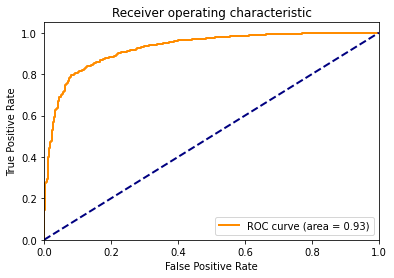

In [25]:
%cd /content/CNNDetection
%run demo_dir.py -d testDir -m weights/blur_jpg_prob0.5.pth

In [26]:
print('Sensitivity: ',(787/(787+1210)))

Sensitivity:  0.3940911367050576


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Not cropping
Loading [1] datasets


100%|██████████| 78/78 [00:24<00:00,  3.17it/s]
No handles with labels found to put in legend.


Average sizes: [224.00+/-0.00] x [224.00+/-0.00] = [0.05+/-0.00 Mpix]
Num reals: 481, Num fakes: 1997
AP: 91.22, Acc: 55.49, Acc (real): 80.04, Acc (fake): 49.57, AUC: 70.09
------CONFUSION MATRIX------
[[ 385   96]
 [1007  990]]
----------------------------


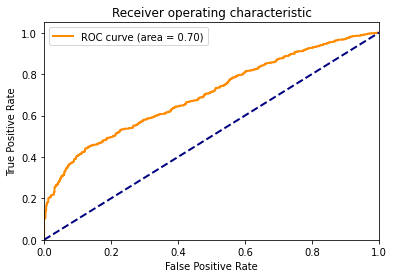

In [27]:
%run demo_dir.py -d testDir -m weights/blur_jpg_prob0.1.pth

In [ ]:
print('Sensitivty: ',(1085/(1085+912)))

Sensitivty:  0.543314972458688


## BASELINE RESULTS FOR THE CNN NETWORK

In [28]:
def setBaseline():
  if os.path.isdir(mysys['testDir']):
    cleanUpTestFolder()
  setUpCNNApp()

  #copy real to testDir/real
  
  copyTree(srcFolder= mysys['cnnCarRealPath'], destFolder=os.path.join(mysys['testDir'],mysys['realPathSuffix']),limit=50, pfx='c')
  copyTree(srcFolder= mysys['cnnDogRealPath'], destFolder=os.path.join(mysys['testDir'],mysys['realPathSuffix']),limit=50,pfx='d')
  copyTree(srcFolder= mysys['cnnPeopleRealPath'], destFolder=os.path.join(mysys['testDir'],mysys['realPathSuffix']),limit=50, pfx='p')
  #copy fake to testDIR/fake
  copyTree(srcFolder= mysys['cnnCarFakePath'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']), pfx='c')
  copyTree(srcFolder= mysys['cnnDogFakePath'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']),pfx='d')
  copyTree(srcFolder= mysys['cnnPeopleFakePath'], destFolder=os.path.join(mysys['testDir'],mysys['fakePathSuffix']),pfx='p')
  
  fakeCount = len(os.listdir(os.path.join(mysys['testDir'],mysys['fakePathSuffix'])))
  realCount = len(os.listdir(os.path.join(mysys['testDir'],mysys['realPathSuffix'])))
  print('Fakes count: ',fakeCount)
  print('Real count: ',realCount)
  print('Real to Fake Ratio: {:.3f}'.format(realCount/fakeCount))

In [29]:
setBaseline()

CLEANUP OF:/content/CNNDetection/testDir: +1
REAL PATH: +1
FAKE PATH: +1
files copied:  /content/gan-analysis-db/cnnTest/car/0_real/  -->  /content/CNNDetection/testDir/0_real :  51
files copied:  /content/gan-analysis-db/cnnTest/dog/0_real/  -->  /content/CNNDetection/testDir/0_real :  51
files copied:  /content/gan-analysis-db/cnnTest/person/0_real/  -->  /content/CNNDetection/testDir/0_real :  51
files copied:  /content/gan-analysis-db/cnnTest/car/1_fake/  -->  /content/CNNDetection/testDir/1_fake :  200
files copied:  /content/gan-analysis-db/cnnTest/dog/1_fake/  -->  /content/CNNDetection/testDir/1_fake :  200
files copied:  /content/gan-analysis-db/cnnTest/person/1_fake/  -->  /content/CNNDetection/testDir/1_fake :  200
Fakes count:  600
Real count:  153
Real to Fake Ratio: 0.255


/content/CNNDetection


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Not cropping
Loading [1] datasets


100%|██████████| 24/24 [00:07<00:00,  3.36it/s]
No handles with labels found to put in legend.


Average sizes: [224.00+/-0.00] x [224.00+/-0.00] = [0.05+/-0.00 Mpix]
Num reals: 153, Num fakes: 600
AP: 100.00, Acc: 100.00, Acc (real): 100.00, Acc (fake): 100.00, AUC: 100.00
------CONFUSION MATRIX------
[[153   0]
 [  0 600]]
----------------------------


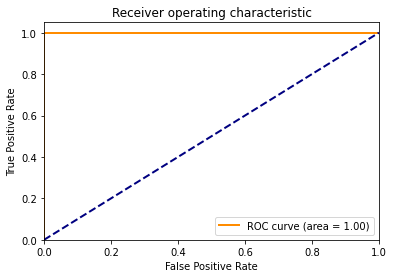

In [30]:
%cd /content/CNNDetection
%run demo_dir.py -d testDir -m weights/blur_jpg_prob0.5.pth

/content/CNNDetection


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Not cropping
Loading [1] datasets


100%|██████████| 24/24 [00:07<00:00,  3.34it/s]
No handles with labels found to put in legend.


Average sizes: [224.00+/-0.00] x [224.00+/-0.00] = [0.05+/-0.00 Mpix]
Num reals: 153, Num fakes: 600
AP: 100.00, Acc: 100.00, Acc (real): 100.00, Acc (fake): 100.00, AUC: 100.00
------CONFUSION MATRIX------
[[153   0]
 [  0 600]]
----------------------------


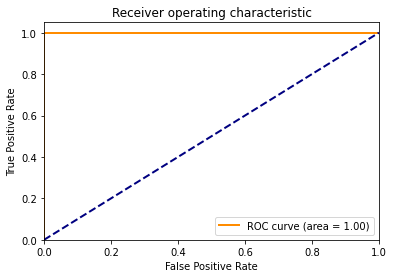

In [31]:
%cd /content/CNNDetection
%run demo_dir.py -d testDir -m weights/blur_jpg_prob0.1.pth